# CPN generator

## Table of contents
1. [Libraries](##Libraries)
2. [Set of the Language](##Set-of-the-Language)
3. [Important functions](##important-functions)
4. [Data Cleaning](#data-cleaning)
5. [Word Embedding](##word-embedding)
6. [Model](#model)
7. [Experiments](#experiments)
8. [Search of hyperparameter *k*](#search-of-hyperparameter-k)


## [Libraries](##Libraries)

In [1]:
import pandas as pd
import numpy as np
import spacy
import gensim
from collections import Counter 
import sklearn.cluster
from sklearn.model_selection import KFold
import random
from scipy.spatial import distance
import time

# Set of the random seed for the kmeans model
random.seed(0)

## [Set of the Language](#Set-of-the-Language)

In [2]:
# Data import
# Relative Path of the dataset, change for your dataset
data = pd.read_csv(r'../data/CPN120/propiedades_codigo.csv', delimiter="\t")

# Import of the model of the spanish billion words embeddings
model = gensim.models.KeyedVectors.load_word2vec_format( 
    r'../../data/SBW-vectors-300-min5.bin.gz', # Relative path of the vector
    binary=True # The model is in binary format
)

# Import of the model of the word2vec-google-news-300 for English dataset
# model = gensim.models.KeyedVectors.load_word2vec_format( 
#     r'../../data/word2vec-google-news-300.model', # Relative path of the vector
#     binary=False # The model is in binary format
# )

In [3]:
# The most important is the 3 rows of Concept, Feature and Code.
# Code is important for the training of the model.
data.head(5)

,Concepto,Respuesta,Codigo
0,granito,tierra,terrestre
1,granito,rugoso,texturas
2,granito,construcción,material_construccion
3,granito,desagradable al tacto,texturas
4,granito,raspa,lastimar


Installation of the Spanish pipeline. Change depending on the language you are using it.

More info in the page of spacy.

In [8]:
# Download each one depending on your language preference

## English
# !python -m spacy download en_core_news_sm

## Spanish
# !python -m spacy download es_core_news_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 245.8 kB/s eta 0:00:52
     --------------------------------------- 0.0/12.8 MB 245.8 kB/s eta 0:00:52
     --------------------------------------- 0.0/12.8 MB 245.8 kB/s eta 0:00:52
     --------------------------------------- 0.1/12.8 MB 385.0 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 385.0 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 312.9 kB/s eta 0:00:41
      -------------------------------------- 0.2/12.8 MB 452.9 kB/s eta 0:00:28
      -------------------------------------- 0.2/12.8 MB 509.6 kB/s eta 0:00:25
      -------------------------------------- 0.2/12.8 MB 509.6 kB/s eta 0:00:25
     - ------------------------------------- 0.3/12.8 MB 599.0 k

In [4]:
# Configuration of spacy for Spanish
nlp = spacy.load('es_core_news_sm')


# Configuration of spacy for English
# nlp = spacy.load('en_core_news_sm')

## [Important functions](##important-functions)

In [5]:
def clean_text(text):
    """
    Recive a string and return the string in tokens without punctuations
    and in lowercase
    """
    # for each token in the sentence add to the list if is not a punctuation
    return [t for t in nlp(text.lower()) if not t.is_punct]


def normalize(tokens):
    """
    Recive al list of string and return in one string without stop words
    """
    # for each token if is not a stop word add the word to the list
    words = [t.orth_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(words))

# Just in case you want to use it replace for normalize
def lematize(tokens):
    """
    Recive al list of string and return in one string without stop words 
    and Lematized
    """
    # for each token if is not a stop word add the lemma of the word in the list
    lemmas = [t.lemma_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(lemmas))


def to_vector(texto, model):
    """ 
    Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence
    """
    tokens = texto.split() # splits the text by space and returns a list of words
    vec = np.zeros(300) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if word in model: # checks if the word is both in the word embedding
            vec += model[word] # adds every word embedding to the vector
    return vec / np.linalg.norm(vec) if np.linalg.norm(vec)>0 else vec # divides the vector by their normal

## [Data Cleaning](##data-cleaning)

In [14]:
start = time.time()
# Normalize of the feature
for i in range(len(data)):
    data['Respuesta'][i] = normalize(clean_text(data['Respuesta'][i])) # Change for the name of your dataset
end = time.time()
print("Exceution time:", end-start)

Exceution time: 110.65806174278259


## [Word Embedding](##word-embedding)

In [15]:
# Timer
start = time.time()


# Creation of the matrix to make the clustering process
descriptions_matrix = np.zeros( # creatign an empty matrix
    (
        len(data), # the number of data points
        len(model['hola']) # the number of components of the word embedding
    )
)

# Matrix filling 
# Change to the name of the descriptions of your dataset.
for i,description in enumerate(data['Respuesta']):
    vector = to_vector(description,model)
    descriptions_matrix[i,] = vector

# Concatenate the matrix with the data of each observation
data_matrix = np.concatenate([descriptions_matrix,data], axis=1)


# Remove of the 'Nan' data
data_matrix = data_matrix[~pd.isnull(data_matrix[:,:300]).any(axis=1)]


# Matrix Reduction
# Is importante to change to the columns in the same orden that is described
data_matrix = np.concatenate(
    (data_matrix[:,:300],                       # Vector of the description
    np.reshape(data_matrix[:,300], (-1, 1)),    # Cue/Concept
    np.reshape(data_matrix[:,302], (-1, 1)),    # Codification
    np.reshape(data_matrix[:,301], (-1, 1))     # Description of the cue
    ),
    axis = 1
)
end = time.time()
print("Exceution time:", end-start)

Exceution time: 2.0810883045196533


## [Model](#model)

We create a class for the text classification, were initially you have to set the number of clusters you want to use for your model.

In [16]:

class AC_PLT:

    def __init__(self, n_clusters = 500):
        """
        n_clusters: number of cluster in the k-Means model
        """
        
        self.n_clusters = n_clusters # number of clusters
        self.KMeans_dict = {} # dictionary of all the humans codifications for each Cluster
        self.KMeans_categories = {} # dictionary for the most frecuent value in the centroid
        self.km = sklearn.cluster.KMeans(n_clusters=self.n_clusters, random_state=0) # creates de k-means object
        
        
    def most_frequent(self, List): 
        """
        Recives a list of words, and return the word most frequente of
        the list
        """
        # counter of occurence of a code in a list
        occurence_count = Counter(List) 
        
        # Return the first code with more occurence
        return occurence_count.most_common(1)[0][0] 


    def fit(self, train):
        """
        Recives the train dataset and the number of clusters to train 
        the k-means model
        """
        # Train the k-means algorithm
        self.km.fit(train[:,:300])

        # Dataframe of train dataset
        df = pd.DataFrame(
            np.concatenate([
                np.reshape(train[:,301], (-1, 1)),          # Human codification
                np.reshape(self.km.labels_, (-1, 1)),       # Number of the KMean centroid
                np.reshape(train[:,300], (-1, 1))           # Concept of the codification
                ], axis=1), 
            columns=['Human', 'KMeans', 'Concept'])

        # create a dictionary of all the humans codifications for each Cluster
        self.KMeans_dict = df.groupby(by='KMeans')['Human'].apply(list).to_dict()

        # Fill a dictionary with the most frecuent value in the centroid
        for key, val in self.KMeans_dict.items():
            self.KMeans_categories[key] = self.most_frequent(val)
        
        # Generates the prediction for the train dataset
        df['KM_Prediction'] = df['KMeans'].map(self.KMeans_categories)


    def get_distances(self, test):
        """
        recives the test data to calculate the distances of each frase, return 
        a matrix with the distances sorted
        """
        
        # Distance matrix of each test point to each cluster center
        distance_matrix = distance.cdist(test[:,:300].astype(float), self.km.cluster_centers_, 'euclidean')
        
        # Sorting distances
        self.topk=np.argsort(distance_matrix,axis=1)
        
    
    def set_labels(self, test):
        """
        Create a new matrix from the clusters sorted and change the value
        from numeric to the string according the codification
        """
        # Change of the numeric value to the codification 
        self.topKS=pd.DataFrame(self.topk)

        # create a temporal array of the kmeans categories
        tempData = np.array([value for (_, value) in sorted(self.KMeans_categories.items())])
        
        # for each cluster center
        for j in range(self.topKS.shape[1]):
            # set the codification of the numeric value in the topk list
            self.topKS.iloc[:,j]=tempData[self.topk[:,j]]


    def get_accuracies(self, test):
        """
        Recives the test matrix and return the accuracies of the 
        diferents predictions
        """
        #Creating the accuracy table to check each data point
        testLabel=np.zeros(self.topKS.shape)
        indexes_method0=pd.DataFrame(np.zeros((self.topKS.shape[0],2)), columns=['index', 'value']) 

        #For each data point
        for i in range(testLabel.shape[0]):
            #Checking if some of the cluster is able to classify it right
            boolClass=self.topKS.iloc[i,:]==test[i,301]
            if sum(boolClass)>0:
                getIndex=boolClass.idxmax()
                indexes_method0.iloc[i,0] = getIndex
                indexes_method0.iloc[i,1] = self.topKS.iloc[i,getIndex]
                #Setting the rest of the data point as 1
                testLabel[i,getIndex:]=1
            else:
                indexes_method0.iloc[i,0] = np.nan
                indexes_method0.iloc[i,1] = np.nan
        accuracies=testLabel.sum(axis=0)/testLabel.shape[0]

        return accuracies

    
    def transform(self, test):
        """
        Recives two numpy bi-dimentionals arrays and returns the accuracy of the model
        """
        self.get_distances(test)
        self.set_labels(test)
        return self.get_accuracies(test)
    

## [Experiments](#experiments)

In [20]:
# K = 500
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k500_acc_top_train = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix):
    train = data_matrix[train_index, :]
    test = data_matrix[test_index, :]
    
    proc = AC_PLT()
    
    print("iteration:", i+1)
    # Train process
    start = time.time()
    proc.fit(train)
    end = time.time()
    print("Train process time:", end-start)
    
    # Clasification process
    start = time.time()
    acc = proc.transform(train)
    end = time.time()
    print("Clasification process time:", end-start)


    for j in range(len(tops)):
        k500_acc_top_train[i,j] = acc[tops[j]]

    i+=1

iteration: 1


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Train process time: 57.80758857727051
Clasification process time: 30.675111293792725
iteration: 2


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Train process time: 55.855494260787964
Clasification process time: 31.147753477096558
iteration: 3


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Train process time: 53.15339708328247
Clasification process time: 32.948052406311035
iteration: 4


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Train process time: 55.734509229660034
Clasification process time: 29.7608859539032
iteration: 5


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Train process time: 60.517739057540894
Clasification process time: 31.25761842727661


In [21]:
print(k500_acc_top_train.mean(axis=0))
print(k500_acc_top_train.std(axis=0))

[0.38026459 0.42567634 0.44362764 0.46632564 0.52526365]
[0.00295876 0.00288369 0.00321152 0.00318692 0.00486809]


In [24]:
# K = 500
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k500_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix):
    train = data_matrix[train_index, :]
    test = data_matrix[test_index, :]

    proc = AC_PLT()
    
    # Train process
    start = time.time()
    proc.fit(train)
    end = time.time()
    print("iteration:", i+1)
    print("Excecution time:", end-start)
    
    # Clasification process
    start = time.time()
    acc = proc.transform(train)
    end = time.time()
    print("Excecution time:", end-start)
    for j in range(len(tops)):
        k500_acc_top[i,j] = acc[tops[j]]

    i+=1

C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iteration: 1
Excecution time: 54.08979034423828
Excecution time: 30.74693012237549


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iteration: 2
Excecution time: 53.162702322006226
Excecution time: 31.03830051422119


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iteration: 3
Excecution time: 52.87960147857666
Excecution time: 31.764637231826782


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iteration: 4
Excecution time: 59.32919692993164
Excecution time: 30.795143842697144


C:\Users\dra98\OneDrive\Documentos\Trabajo\Tesis\Codigo\GeneradorCPN\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iteration: 5
Excecution time: 59.385398149490356
Excecution time: 29.721275568008423


In [25]:
print(k500_acc_top.mean(axis=0))
print(k500_acc_top.std(axis=0))

[0.38026459 0.42567634 0.44362764 0.46632564 0.52526365]
[0.00295876 0.00288369 0.00321152 0.00318692 0.00486809]


## [Search of hyperparameter *k*](#search-of-hyperparameter-k)

In [9]:
from sklearn.model_selection import KFold
rango = range(50,1500+1,10)
tops=[0,2,4,9,49]

# k_acc_1 = np.zeros((len(rango), 2))
# k_acc_1_train = np.zeros((len(rango), 2))

k_acc_top_train = np.zeros((len(rango), 10))
k_acc_top_test = np.zeros((len(rango), 10))


j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    train_temp = np.zeros((5,5))
    test_temp = np.zeros((5,5))

    x = 0
    for train_index, test_index in kfold.split(data_matrix):
        train = data_matrix[train_index, :]
        test = data_matrix[test_index, :]

        proc = AC_PLT(0, k)
        train_acc = proc.train_process(train)
        test_acc = proc.process(train, test)
        
        train_temp[x] = train_acc[tops]
        test_temp[x] = test_acc[tops]
        x+=1

    for i in range(5):
        # print(train_temp.std(axis=0))
        k_acc_top_train[j, i*2] = train_temp.mean(axis=0)[i]
        k_acc_top_train[j, i*2+1] = train_temp.std(axis=0)[i]

        k_acc_top_test[j, i*2] = test_temp.mean(axis=0)[i]
        k_acc_top_test[j, i*2+1] = test_temp.std(axis=0)[i]


    j+=1
    print("K =", k)
    

K = 50
K = 60
K = 70
K = 80
K = 90
K = 100
K = 110
K = 120
K = 130
K = 140
K = 150
K = 160
K = 170
K = 180
K = 190
K = 200
K = 210
K = 220
K = 230
K = 240
K = 250
K = 260
K = 270
K = 280
K = 290
K = 300
K = 310
K = 320
K = 330
K = 340
K = 350
K = 360
K = 370
K = 380
K = 390
K = 400
K = 410
K = 420
K = 430
K = 440
K = 450
K = 460
K = 470
K = 480
K = 490
K = 500
K = 510
K = 520
K = 530
K = 540
K = 550
K = 560
K = 570
K = 580
K = 590
K = 600
K = 610
K = 620
K = 630
K = 640
K = 650
K = 660
K = 670
K = 680
K = 690
K = 700
K = 710
K = 720
K = 730
K = 740
K = 750
K = 760
K = 770
K = 780
K = 790
K = 800
K = 810
K = 820
K = 830
K = 840
K = 850
K = 860
K = 870
K = 880
K = 890
K = 900
K = 910
K = 920
K = 930
K = 940
K = 950
K = 960
K = 970
K = 980
K = 990
K = 1000
K = 1010
K = 1020
K = 1030
K = 1040
K = 1050
K = 1060
K = 1070
K = 1080
K = 1090
K = 1100
K = 1110
K = 1120
K = 1130
K = 1140
K = 1150
K = 1160
K = 1170
K = 1180
K = 1190
K = 1200
K = 1210
K = 1220
K = 1230
K = 1240
K = 1250
K = 1260
K 

In [33]:
# df1 = pd.DataFrame(k_acc_top_test)
# df2 = pd.DataFrame(k_acc_top_train)

# df1
np.savetxt("k_acc_top_test.csv",k_acc_top_test,delimiter=',')
np.savetxt("k_acc_top_train.csv",k_acc_top_train,delimiter=',')
# df1.to_csv("k_acc_top_test.csv")
# df2.to_csv("k_acc_top_train.csv")


In [2]:
k_acc_top_test=pd.read_csv(r"k_acc_top_test.csv", header=None).to_numpy()
k_acc_top_train=pd.read_csv(r"k_acc_top_train.csv", header=None).to_numpy()

rango = range(50,1500+1,10)

In [17]:
print("top-1 (k=500)=", k_acc_top_test[rango.index(500),0],"",k_acc_top_test[rango.index(500),1])
print("top-3 (k=500)=", k_acc_top_test[rango.index(500),2],"",k_acc_top_test[rango.index(500),3])
print("top-50 (k=500)=", k_acc_top_test[rango.index(500),8],"",k_acc_top_test[rango.index(500),9])

top-1 (k=500)= 0.36470205144903933  0.0069595832015070256
top-3 (k=500)= 0.41322044936502766  0.005989232636157389
top-50 (k=500)= 0.5256919570172582  0.009875891937358402


No module named 'seaborn'


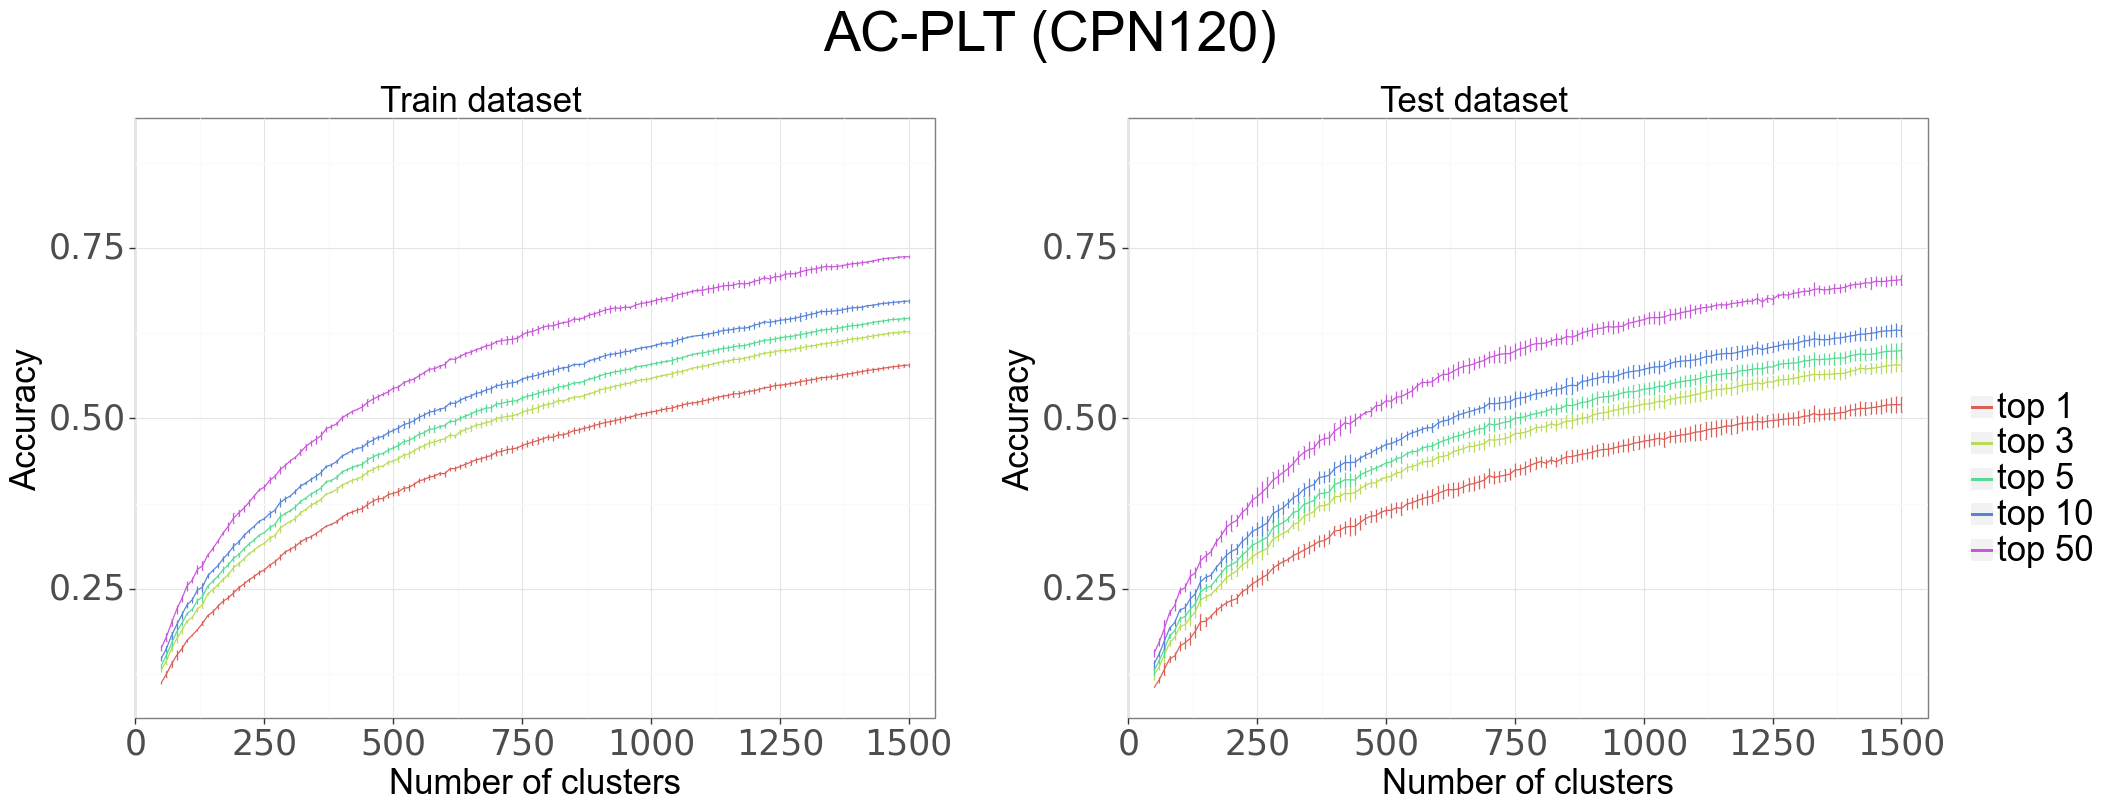

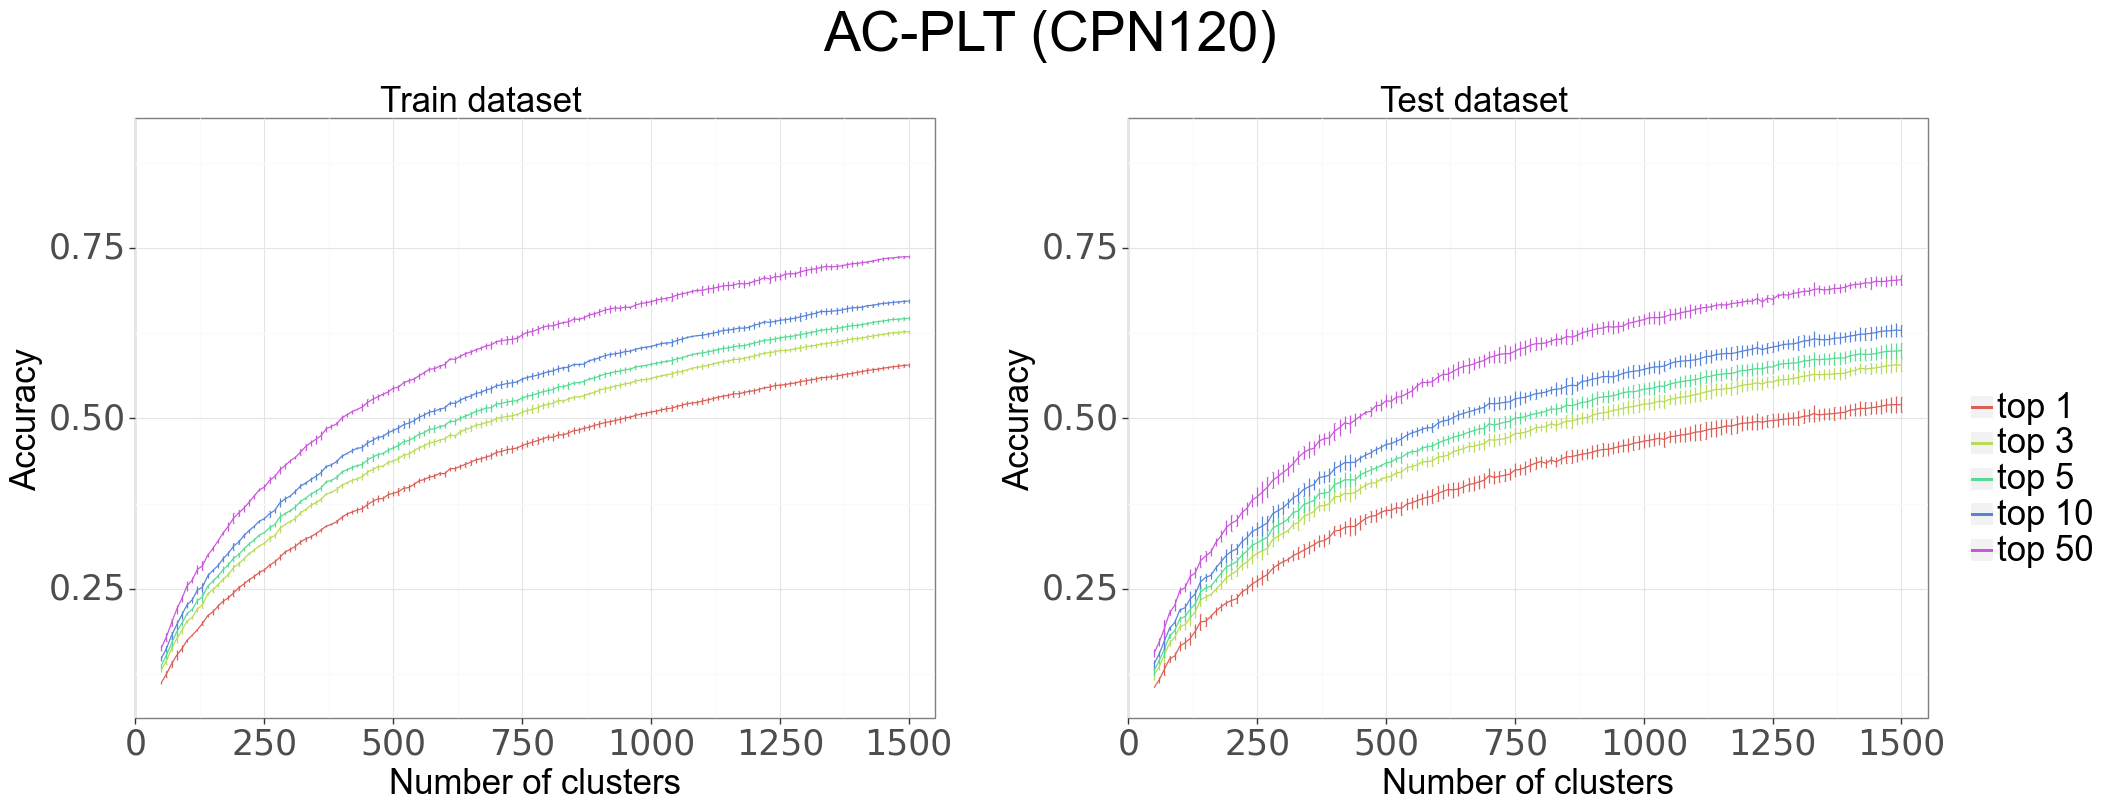

In [3]:
from numpy import size
from plotnine import *

p1 = (
    ggplot()+
    aes(x=rango, color='')+
    geom_line(aes(y=k_acc_top_test[:,0], color="'top 1'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,0]-k_acc_top_test[:,1], ymax = k_acc_top_test[:,0]+k_acc_top_test[:,1], color="'top 1'"))+
    geom_line(aes(y=k_acc_top_test[:,2], color="'top 3'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,2]-k_acc_top_test[:,3], ymax = k_acc_top_test[:,2]+k_acc_top_test[:,3], color="'top 3'"))+
    geom_line(aes(y=k_acc_top_test[:,4], color="'top 5'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,4]-k_acc_top_test[:,5], ymax = k_acc_top_test[:,4]+k_acc_top_test[:,5], color="'top 5'"))+
    geom_line(aes(y=k_acc_top_test[:,6], color="'top 10'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,6]-k_acc_top_test[:,7], ymax = k_acc_top_test[:,6]+k_acc_top_test[:,7], color="'top 10'"))+
    geom_line(aes(y=k_acc_top_test[:,8], color="'top 50'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,8]-k_acc_top_test[:,9], ymax = k_acc_top_test[:,8]+k_acc_top_test[:,9], color="'top 50'"))+
    xlab("Number of clusters")+
    ylab("Accuracy")+
    ggtitle("Test dataset")+
    theme_bw()+
    theme(text=element_text(size=25))+
    scale_y_continuous(limits = (0.1, 0.9))+
    scale_x_continuous(limits=(0, 1550), breaks=range(0, 1501, 250), expand=(0,1))
)

p2 = (
    ggplot()+
    aes(x=rango, color='')+
    geom_line(aes(y=k_acc_top_train[:,0], color="'top 1'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,0]-k_acc_top_train[:,1], ymax = k_acc_top_train[:,0]+k_acc_top_train[:,1], color="'top 1'"))+
    geom_line(aes(y=k_acc_top_train[:,2], color="'top 3'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,2]-k_acc_top_train[:,3], ymax = k_acc_top_train[:,2]+k_acc_top_train[:,3], color="'top 3'"))+
    geom_line(aes(y=k_acc_top_train[:,4], color="'top 5'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,4]-k_acc_top_train[:,5], ymax = k_acc_top_train[:,4]+k_acc_top_train[:,5], color="'top 5'"))+
    geom_line(aes(y=k_acc_top_train[:,6], color="'top 10'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,6]-k_acc_top_train[:,7], ymax = k_acc_top_train[:,6]+k_acc_top_train[:,7], color="'top 10'"))+
    geom_line(aes(y=k_acc_top_train[:,8], color="'top 50'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,8]-k_acc_top_train[:,9], ymax = k_acc_top_train[:,8]+k_acc_top_train[:,9], color="'top 50'"))+
    xlab("Number of clusters")+
    ylab("Accuracy")+
    ggtitle("Train dataset")+
    theme_bw()+
    theme(legend_position = "none", text=element_text(size=25))+
    scale_y_continuous(limits = (0.1, 0.9))+
    scale_x_continuous(limits=(0, 1550), breaks=range(0, 1501, 250), expand=(0,1))
)

# gray = 

p1 = pw.load_ggplot(p1, figsize=(8,6))
p2 = pw.load_ggplot(p2, figsize=(8,6))

p12 = (p2|p1)
p12.set_text(text="AC-PLT (CPN120)",x=0.42,y=1.1, size=40)
p12.savefig("/your-route/your-file.png")